In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, f1_score, classification_report
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics, datasets, preprocessing
from sklearn import model_selection
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import seaborn as sns

In [2]:
df = pd.read_csv('RT_IOT2022.csv')
df = df.copy()

In [3]:
df['Attack_type'].value_counts()

Attack_type
DOS_SYN_Hping                 94659
Alexa                         86842
Thing_Speak                    8108
ARP_poisioning                 7750
MQTT_Publish                   4146
NMAP_UDP_SCAN                  2590
NMAP_XMAS_TREE_SCAN            2010
NMAP_OS_DETECTION              2000
NMAP_TCP_scan                  1002
DDOS_Slowloris                  534
Wipro_bulb                      253
Metasploit_Brute_Force_SSH       37
NMAP_FIN_SCAN                    28
Name: count, dtype: int64

In [4]:
df.shape

(209959, 84)

## Drop unnecessary cols for ML 
- .min and .max cols 
- id cols, proto and service  


In [6]:
df_drop = []

df_drop = [col for col in df.columns if col.endswith(('.min', '.max', '_min', '_max'))]

df_drop += ['id.orig_p', 'id.resp_p', 'proto', 'service']

df = df.drop(df_drop, axis=1, errors='ignore')

In [7]:
# Find proportion of the most frequent value in each column
dominant_ratio = df.apply(lambda x: x.value_counts(normalize=True).max())

# Filter columns where the most frequent value occurs in ≥90% of the rows
high_dominance_cols = dominant_ratio[dominant_ratio >= 0.9]

print(high_dominance_cols)


fwd_URG_flag_count     0.990446
bwd_URG_flag_count     1.000000
flow_CWR_flag_count    0.999662
flow_ECE_flag_count    0.999657
active.std             0.913421
idle.std               0.993865
dtype: float64


In [14]:
df_drop = high_dominance_cols.index.tolist()

df = df.drop(df_drop, axis=1, errors='ignore')

df.shape

(209959, 54)

In [16]:
# Compute correlation matrix on numeric columns
corr_matrix = df.drop('Attack_type', axis=1).corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation > 0.95
to_drop_corr = [column for column in upper.columns if any(upper[column] > 0.95)]

print(f"Dropping {len(to_drop_corr)} highly correlated features:")
print(to_drop_corr)

# Drop them
df = df.drop(columns=to_drop_corr)

Dropping 18 highly correlated features:
['fwd_data_pkts_tot', 'bwd_pkts_per_sec', 'flow_pkts_per_sec', 'fwd_header_size_tot', 'bwd_header_size_tot', 'fwd_PSH_flag_count', 'flow_ACK_flag_count', 'fwd_pkts_payload.tot', 'bwd_pkts_payload.tot', 'flow_pkts_payload.tot', 'fwd_iat.tot', 'flow_iat.tot', 'flow_iat.std', 'payload_bytes_per_second', 'bwd_bulk_bytes', 'bwd_bulk_packets', 'idle.tot', 'idle.avg']


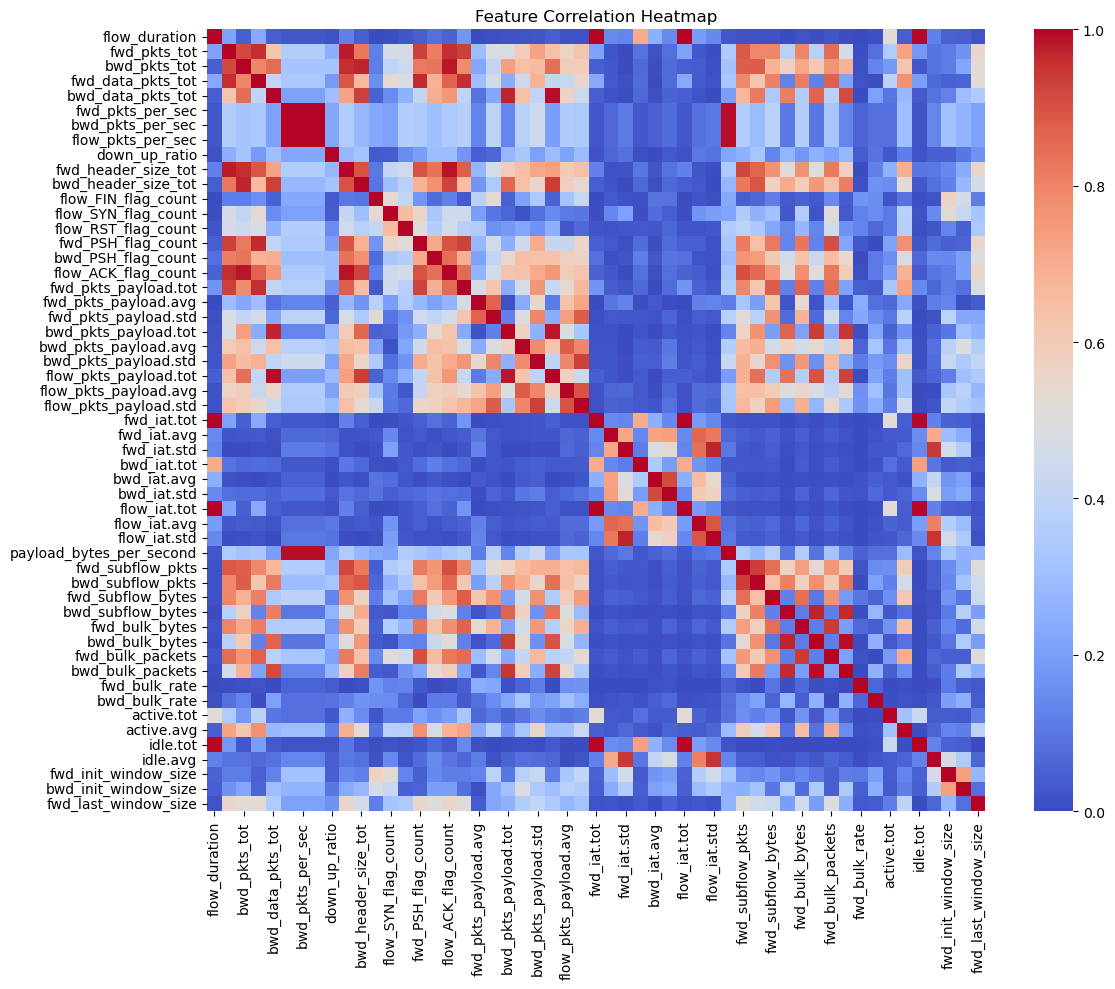

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', vmax=1.0, vmin=0.0)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

In [20]:
# Drop based on feature importance from models 
features_to_drop = [
    'fwd_iat.std',
    'active.avg',
    'bwd_subflow_pkts',
    'bwd_pkts_tot',
    'bwd_pkts_payload.avg',
    'flow_pkts_payload.std'
]

# df = df.drop(columns=features_to_drop)

df.shape

(209959, 36)

In [22]:
# Encode attack_type for Binary class
df["attack_type_encoded"] = df["Attack_type"].apply(lambda x: 1 if x in ["DOS_SYN_Hping", "ARP_poisioning", "NMAP_UDP_SCAN", "NMAP_XMAS_TREE_SCAN", "NMAP_OS_DETECTION", "NMAP_TCP_scan", "DDOS_Slowloris", "Metasploit_Brute_Force_SSH", "NMAP_FIN_SCAN"] else 0)
df = df.drop(columns=['Attack_type'])
df.head(20)

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,down_up_ratio,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,bwd_PSH_flag_count,...,fwd_bulk_bytes,fwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.tot,active.avg,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,attack_type_encoded
0,0.005875,1,1,1,170.209561,1.000000,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,5.875111e+03,5.875111e+03,0,0,0,0
1,7.807541,159,144,38,20.364926,0.905660,0,0,0,23,...,13886.500000,62.500000,10096.717546,33346.967364,7.807541e+06,7.807541e+06,11890,3216,11890,0
2,0.216894,7,7,2,32.273807,1.000000,3,2,0,2,...,0.000000,0.000000,0.000000,0.000000,3.060679e+05,3.060679e+05,29200,29200,1065,0
3,0.014496,10,10,10,689.841286,1.000000,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,1.449609e+04,1.449609e+04,0,0,0,0
4,8.797776,158,176,45,17.959084,1.113924,0,0,0,38,...,27531.000000,124.000000,10251.481385,32467.560574,8.797776e+06,8.797776e+06,11890,3220,11890,0
5,7.847601,178,161,38,22.682091,0.904494,0,0,0,23,...,14879.666667,48.333333,14842.101720,42038.167273,7.847601e+06,7.847601e+06,7245,5188,7245,0
6,9.474946,168,172,37,17.730972,1.023810,0,0,0,22,...,28454.000000,132.000000,10112.016268,49141.440419,9.474946e+06,9.474946e+06,11890,3076,11890,0
7,7.651963,164,148,37,21.432409,0.902439,0,0,0,22,...,13924.500000,65.000000,10024.751557,39765.846799,7.651963e+06,7.651963e+06,11890,3216,11890,0
8,7.992142,172,123,37,21.521139,0.715116,0,0,0,23,...,14470.500000,70.000000,9945.059868,32964.398487,7.992142e+06,7.992142e+06,11890,3216,11890,0
9,7.793000,167,155,38,21.429488,0.928144,0,0,0,21,...,10891.250000,34.500000,16069.865981,36565.430773,7.793000e+06,7.793000e+06,7245,5188,7245,0


## Train-Test-Val split

In [25]:
x = df.drop(columns = ['attack_type_encoded'])
y = df['attack_type_encoded']

x_train_f, x_test, y_train_f, y_test = model_selection.train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = model_selection.train_test_split(x_train_f, y_train_f, test_size=0.1, random_state=18)

## Logistic Regression

In [33]:
estimator = linear_model.LogisticRegression(C=100000000000, max_iter=10000, penalty="l2")
estimator.fit(x_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=100000000000, max_iter=10000)

### Validaton

In [31]:
y_probs = estimator.predict_proba(x_val)[:, 1]
y_pred = estimator.predict(x_val)

print('\nClassification Report:\n', metrics.classification_report(y_val, y_pred))

print('\nConfusion Matrix\n', metrics.confusion_matrix(y_val, y_pred))

print('\nAUC:', metrics.roc_auc_score(y_val, y_probs))

print("f1 score: ", metrics.f1_score(y_val, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.98      0.90      8001
           1       0.98      0.83      0.90      8796

    accuracy                           0.90     16797
   macro avg       0.91      0.90      0.90     16797
weighted avg       0.91      0.90      0.90     16797


Confusion Matrix
 [[7847  154]
 [1510 7286]]

AUC: 0.9880023381570255
f1 score:  0.8975117023897512


### Train

In [35]:
y_probs = estimator.predict_proba(x_train)[:, 1]
y_pred = estimator.predict(x_train)

print('\nClassification Report:\n', metrics.classification_report(y_train, y_pred))

print('\nConfusion Matrix\n', metrics.confusion_matrix(y_train, y_pred))

print('\nAUC:', metrics.roc_auc_score(y_train, y_probs))

print("f1 score: ", metrics.f1_score(y_train, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.92      0.87     71558
           1       0.92      0.84      0.88     79612

    accuracy                           0.88    151170
   macro avg       0.88      0.88      0.88    151170
weighted avg       0.88      0.88      0.88    151170


Confusion Matrix
 [[65653  5905]
 [12945 66667]]

AUC: 0.980750736333101
f1 score:  0.8761367817904642


### Test

In [37]:
y_probs = estimator.predict_proba(x_test)[:, 1]
y_pred = estimator.predict(x_test)

print('\nClassification Report:\n', metrics.classification_report(y_test, y_pred))

print('\nConfusion Matrix\n', metrics.confusion_matrix(y_test, y_pred))

print('\nAUC:', metrics.roc_auc_score(y_test, y_probs))

print("f1 score: ", metrics.f1_score(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.92      0.88     19790
           1       0.92      0.84      0.88     22202

    accuracy                           0.88     41992
   macro avg       0.88      0.88      0.88     41992
weighted avg       0.88      0.88      0.88     41992


Confusion Matrix
 [[18183  1607]
 [ 3583 18619]]

AUC: 0.9810743210884816
f1 score:  0.8776751202036391


In [39]:
import joblib

# Save the full stacking model
joblib.dump(estimator, "binary_logistic_regression.pkl")

['binary_logistic_regression.pkl']

## XGBoost

In [41]:
estimator = XGBClassifier()


estimator.fit(x_train, y_train, eval_set=[(x_val, y_val)], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

### Validation

In [43]:
y_probs = estimator.predict_proba(x_val)[:, 1]
y_pred = estimator.predict(x_val)

print('\nClassification Report:\n', metrics.classification_report(y_val, y_pred))

print('\nConfusion Matrix\n', metrics.confusion_matrix(y_val, y_pred))

print('\nAUC:', metrics.roc_auc_score(y_val, y_probs))

print("f1 score: ", metrics.f1_score(y_val, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8001
           1       1.00      1.00      1.00      8796

    accuracy                           1.00     16797
   macro avg       1.00      1.00      1.00     16797
weighted avg       1.00      1.00      1.00     16797


Confusion Matrix
 [[7977   24]
 [   3 8793]]

AUC: 0.999986991450989
f1 score:  0.9984670413898825


### Train

In [45]:
y_probs = estimator.predict_proba(x_train)[:, 1]
y_pred = estimator.predict(x_train)

print('\nClassification Report:\n', metrics.classification_report(y_train, y_pred))

print('\nConfusion Matrix\n', metrics.confusion_matrix(y_train, y_pred))

print('\nAUC:\n', metrics.roc_auc_score(y_train, y_probs))

print("f1 score: ", metrics.f1_score(y_train, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     71558
           1       1.00      1.00      1.00     79612

    accuracy                           1.00    151170
   macro avg       1.00      1.00      1.00    151170
weighted avg       1.00      1.00      1.00    151170


Confusion Matrix
 [[71339   219]
 [    4 79608]]

AUC:
 0.9999862170939043
f1 score:  0.9986013459693048


### Test

In [48]:
y_probs = estimator.predict_proba(x_test)[:, 1]
y_pred = estimator.predict(x_test)

print('\nClassification Report:\n', metrics.classification_report(y_test, y_pred))

print('\nConfusion Matrix\n', metrics.confusion_matrix(y_test, y_pred))

print('\nAUC:\n', metrics.roc_auc_score(y_test, y_probs))

print("f1 score: ", metrics.f1_score(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19790
           1       1.00      1.00      1.00     22202

    accuracy                           1.00     41992
   macro avg       1.00      1.00      1.00     41992
weighted avg       1.00      1.00      1.00     41992


Confusion Matrix
 [[19718    72]
 [   14 22188]]

AUC:
 0.9999764348467666
f1 score:  0.9980657640232108


In [50]:
joblib.dump(estimator, "binary_xgboost.pkl")

['binary_xgboost.pkl']

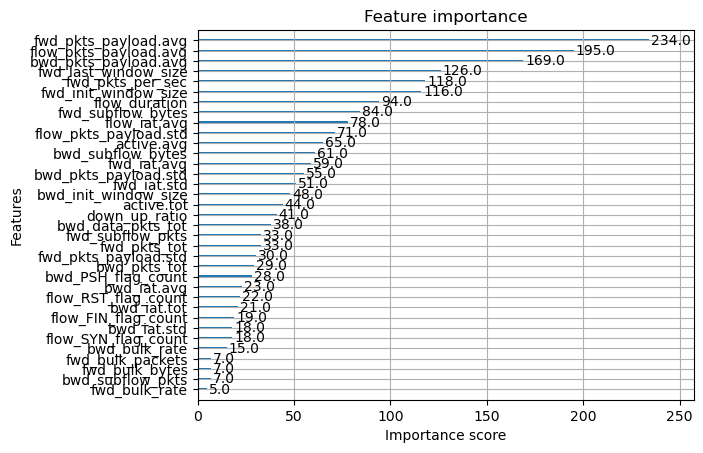

In [83]:
from xgboost import plot_importance
from matplotlib import pyplot

plot_importance(estimator)
pyplot.show()

## Random Forest

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Initialize the model
estimator = RandomForestClassifier(random_state=42)

# Train the model
estimator.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

### Validation

In [54]:
y_probs = estimator.predict_proba(x_val)[:, 1]
y_pred = estimator.predict(x_val)

print('\nClassification Report:\n', metrics.classification_report(y_val, y_pred))

print('\nConfusion Matrix\n', metrics.confusion_matrix(y_val, y_pred))

print('\nAUC:', metrics.roc_auc_score(y_val, y_probs))

print("f1 score: ", metrics.f1_score(y_val, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8001
           1       1.00      1.00      1.00      8796

    accuracy                           1.00     16797
   macro avg       1.00      1.00      1.00     16797
weighted avg       1.00      1.00      1.00     16797


Confusion Matrix
 [[7982   19]
 [   6 8790]]

AUC: 0.9999851229373954
f1 score:  0.9985799488781596


### Train

In [55]:
y_probs = estimator.predict_proba(x_train)[:, 1]
y_pred = estimator.predict(x_train)

print('\nClassification Report:\n', metrics.classification_report(y_train, y_pred))

print('\nConfusion Matrix\n', metrics.confusion_matrix(y_train, y_pred))

print('\nAUC:\n', metrics.roc_auc_score(y_train, y_probs))

print("f1 score: ", metrics.f1_score(y_train, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     71558
           1       1.00      1.00      1.00     79612

    accuracy                           1.00    151170
   macro avg       1.00      1.00      1.00    151170
weighted avg       1.00      1.00      1.00    151170


Confusion Matrix
 [[71374   184]
 [    7 79605]]

AUC:
 0.9999877558321137
f1 score:  0.9988017641043657


### Test

In [60]:
y_probs = estimator.predict_proba(x_test)[:, 1]
y_pred = estimator.predict(x_test)

print('\nClassification Report:\n', metrics.classification_report(y_test, y_pred))

print('\nConfusion Matrix\n', metrics.confusion_matrix(y_test, y_pred))

print('\nAUC:\n', metrics.roc_auc_score(y_test, y_probs))

print("f1 score: ", metrics.f1_score(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19790
           1       1.00      1.00      1.00     22202

    accuracy                           1.00     41992
   macro avg       1.00      1.00      1.00     41992
weighted avg       1.00      1.00      1.00     41992


Confusion Matrix
 [[19732    58]
 [   21 22181]]

AUC:
 0.9998745691575797
f1 score:  0.998222362233073


In [62]:
joblib.dump(estimator, "binary_random_forest.pkl")

['binary_random_forest.pkl']

## TabNet

In [64]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor

In [65]:
clf = TabNetClassifier()

clf.fit(
    X_train=x_train.values, 
    y_train=y_train.values,
    eval_set=[(x_val.values, y_val.values)],
    eval_name=['val'],
    eval_metric=['auc'], 
    max_epochs=100,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
)

/opt/anaconda3/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.17606 | val_auc: 0.99395 |  0:00:02s
epoch 1  | loss: 0.07605 | val_auc: 0.99648 |  0:00:04s
epoch 2  | loss: 0.06541 | val_auc: 0.99725 |  0:00:07s
epoch 3  | loss: 0.05655 | val_auc: 0.99774 |  0:00:09s
epoch 4  | loss: 0.05473 | val_auc: 0.99734 |  0:00:11s
epoch 5  | loss: 0.05245 | val_auc: 0.99736 |  0:00:13s
epoch 6  | loss: 0.06537 | val_auc: 0.99766 |  0:00:16s
epoch 7  | loss: 0.05526 | val_auc: 0.9974  |  0:00:18s
epoch 8  | loss: 0.0717  | val_auc: 0.99621 |  0:00:20s
epoch 9  | loss: 0.06929 | val_auc: 0.99722 |  0:00:22s
epoch 10 | loss: 0.07325 | val_auc: 0.99556 |  0:00:24s
epoch 11 | loss: 0.06114 | val_auc: 0.99824 |  0:00:26s
epoch 12 | loss: 0.05326 | val_auc: 0.99843 |  0:00:29s
epoch 13 | loss: 0.04961 | val_auc: 0.99861 |  0:00:31s
epoch 14 | loss: 0.06012 | val_auc: 0.99743 |  0:00:33s
epoch 15 | loss: 0.04609 | val_auc: 0.99817 |  0:00:35s
epoch 16 | loss: 0.04209 | val_auc: 0.99845 |  0:00:38s
epoch 17 | loss: 0.04033 | val_auc: 0.9987  |  0

/opt/anaconda3/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


### Validation

In [68]:
y_probs = clf.predict_proba(x_val.values)[:, 1]
y_pred = clf.predict(x_val.values)

print('\nClassification Report:\n', metrics.classification_report(y_val.values, y_pred))

print('\nConfusion Matrix\n', metrics.confusion_matrix(y_val.values, y_pred))

print('\nAUC:', metrics.roc_auc_score(y_val.values, y_probs))

print("f1 score: ", metrics.f1_score(y_val.values, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      8001
           1       0.99      1.00      0.99      8796

    accuracy                           0.99     16797
   macro avg       0.99      0.99      0.99     16797
weighted avg       0.99      0.99      0.99     16797


Confusion Matrix
 [[7883  118]
 [  25 8771]]

AUC: 0.9997421593333121
f1 score:  0.9919140514560362


### Train

In [70]:
y_probs = clf.predict_proba(x_train.values)[:, 1]
y_pred = clf.predict(x_train.values)

print('\nClassification Report:\n', metrics.classification_report(y_train.values, y_pred))

print('\nConfusion Matrix\n', metrics.confusion_matrix(y_train.values, y_pred))

print('\nAUC:', metrics.roc_auc_score(y_train.values, y_probs))

print("f1 score: ", metrics.f1_score(y_train.values, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     71558
           1       0.99      1.00      0.99     79612

    accuracy                           0.99    151170
   macro avg       0.99      0.99      0.99    151170
weighted avg       0.99      0.99      0.99    151170


Confusion Matrix
 [[70471  1087]
 [  209 79403]]

AUC: 0.9996895545635073
f1 score:  0.9919051604602066


### Test

In [72]:
y_probs = clf.predict_proba(x_test.values)[:, 1]
y_pred = clf.predict(x_test.values)

print('\nClassification Report:\n', metrics.classification_report(y_test.values, y_pred))

print('\nConfusion Matrix\n', metrics.confusion_matrix(y_test.values, y_pred))

print('\nAUC:', metrics.roc_auc_score(y_test.values, y_probs))

print("f1 score: ", metrics.f1_score(y_test.values, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     19790
           1       0.99      1.00      0.99     22202

    accuracy                           0.99     41992
   macro avg       0.99      0.99      0.99     41992
weighted avg       0.99      0.99      0.99     41992


Confusion Matrix
 [[19466   324]
 [   64 22138]]

AUC: 0.9996040922251883
f1 score:  0.991312914203833


In [74]:
clf.save_model("binary_tabnet_model")

Successfully saved model at binary_tabnet_model.zip


'binary_tabnet_model.zip'